In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline


def cosine_similarity(queries, dataset):
    queries = queries / np.linalg.norm(queries, axis=1, keepdims=True)
    dataset = dataset / np.linalg.norm(dataset, axis=1, keepdims=True)
    return queries.dot(dataset.T)


def ranking(similarities, target_indices):
    sorted_ds_indices = np.argsort(-similarities, axis=1)

    ranks = []
    for result_list, target in zip(sorted_ds_indices, target_indices):
        rank = np.where(result_list == target)[0][0] + 1
        ranks.append(rank)
    return np.sort(ranks)

# Read data

In [2]:
targets = np.frombuffer(open("data/targets.bin", "rb").read(), dtype=np.int32)

BertD = np.frombuffer(open("data/bert_dataset.bin", "rb").read(), dtype=np.float16).reshape(-1, 2048)
BertQ = np.frombuffer(open("data/bert_queries.bin", "rb").read(), dtype=np.float16).reshape(-1, 2048)

ClipD = np.frombuffer(open("data/clip_dataset.bin", "rb").read(), dtype=np.float16).reshape(-1, 640)
ClipQ = np.frombuffer(open("data/clip_queries.bin", "rb").read(), dtype=np.float16).reshape(-1, 640)

print("Shapes:", targets.shape, BertD.shape, BertQ.shape, ClipD.shape, ClipQ.shape)

# Cast to float32 (faster computation on CPU using vector instructions)
BertD = BertD.astype(np.float32)
BertQ = BertQ.astype(np.float32)
ClipD = ClipD.astype(np.float32)
ClipQ = ClipQ.astype(np.float32)

# L2 normalize vectors
BertD_normed = BertD / np.linalg.norm(BertD, axis=-1, keepdims=True)
BertQ_normed = BertQ / np.linalg.norm(BertQ, axis=-1, keepdims=True)

ClipD_normed = ClipD / np.linalg.norm(ClipD, axis=-1, keepdims=True)
ClipQ_normed = ClipQ / np.linalg.norm(ClipQ, axis=-1, keepdims=True)

Shapes: (327,) (20000, 2048) (327, 2048) (20000, 640) (327, 640)


# CLIP vs. BERT features

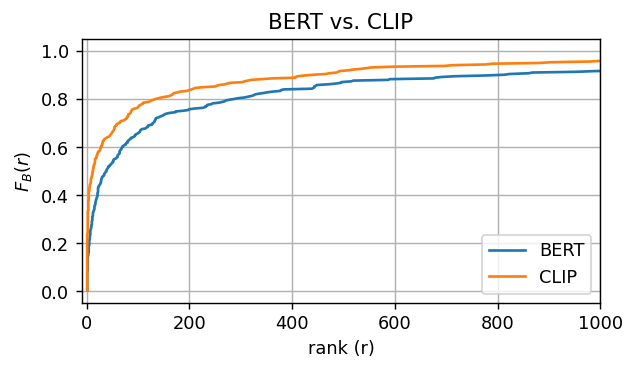

In [3]:
bert_results = ranking(cosine_similarity(queries=BertQ, dataset=BertD), targets)
clip_results = ranking(cosine_similarity(queries=ClipQ, dataset=ClipD), targets)

plt.figure(figsize=(5,3), dpi=128)
plt.title("BERT vs. CLIP")
plt.xlabel("rank (r)")
plt.ylabel("$F_B(r)$")
plt.tight_layout()
plt.grid()
plt.xlim((-10,1000))

recall = np.arange(1, len(clip_results) + 1, dtype=np.float32) / len(clip_results)
plt.plot(bert_results, recall, label="BERT")
plt.plot(clip_results, recall, label="CLIP")
plt.legend(loc="lower right")
pass

# Dimensionality reduction

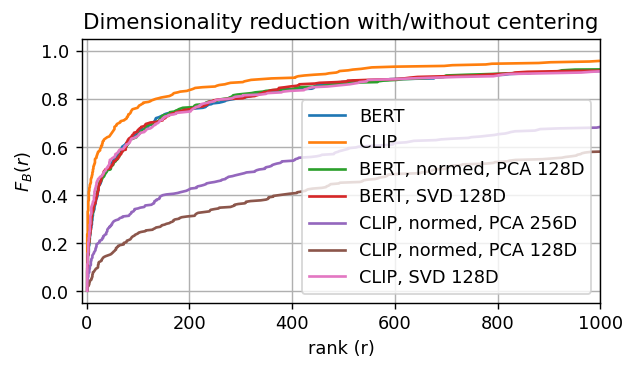

In [4]:
pca = PCA(n_components=128).fit(BertD_normed)
bert_pca128_results = ranking(cosine_similarity(queries=pca.transform(BertQ_normed), dataset=pca.transform(BertD_normed)), targets)

_, _, Vt = np.linalg.svd(BertD, full_matrices=False)
bert_svd128_results = ranking(cosine_similarity(queries=BertQ @ Vt[:128].T, dataset=BertD @ Vt[:128].T), targets)

pca = PCA(n_components=128).fit(ClipD_normed)
clip_pca128_results = ranking(cosine_similarity(queries=pca.transform(ClipQ_normed), dataset=pca.transform(ClipD_normed)), targets)

pca = PCA(n_components=256).fit(ClipD_normed)
clip_pca256_results = ranking(cosine_similarity(queries=pca.transform(ClipQ_normed), dataset=pca.transform(ClipD_normed)), targets)

_, _, Vt = np.linalg.svd(ClipD, full_matrices=False)
clip_svd128_results = ranking(cosine_similarity(queries=ClipQ @ Vt[:128].T, dataset=ClipD @ Vt[:128].T), targets)

plt.figure(figsize=(5,3), dpi=128)
plt.title("Dimensionality reduction with/without centering")
plt.xlabel("rank (r)")
plt.ylabel("$F_B(r)$")
plt.tight_layout()
plt.grid()
plt.xlim((-10,1000))

recall = np.arange(1, len(clip_results) + 1, dtype=np.float32) / len(clip_results)
plt.plot(bert_results, recall, label="BERT")
plt.plot(clip_results, recall, label="CLIP")
plt.plot(bert_pca128_results, recall, label="BERT, normed, PCA 128D")
plt.plot(bert_svd128_results, recall, label="BERT, SVD 128D")
plt.plot(clip_pca256_results, recall, label="CLIP, normed, PCA 256D")
plt.plot(clip_pca128_results, recall, label="CLIP, normed, PCA 128D")
plt.plot(clip_svd128_results, recall, label="CLIP, SVD 128D")
plt.legend(loc="lower right")
pass

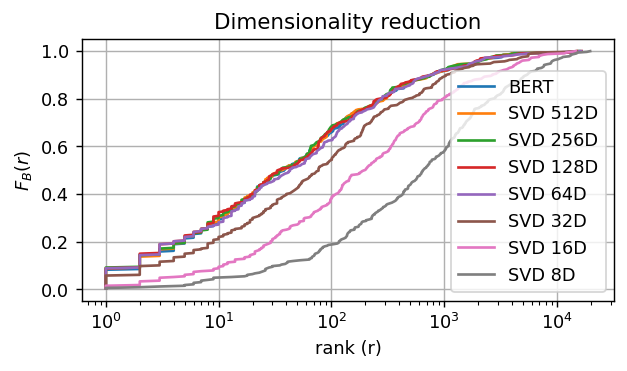

In [5]:
_, _, Vt = np.linalg.svd(BertD, full_matrices=False)
bert_svd_results = []
for dim in [512, 256, 128, 64, 32, 16, 8]:
    bert_svd_results.append((dim, ranking(cosine_similarity(queries=BertQ @ Vt[:dim].T, dataset=BertD @ Vt[:dim].T), targets)))

plt.figure(figsize=(5,3), dpi=128)
plt.title("Dimensionality reduction")
plt.xscale("log")
plt.xlabel("rank (r)")
plt.ylabel("$F_B(r)$")
plt.tight_layout()
plt.grid()

recall = np.arange(1, len(clip_results) + 1, dtype=np.float32) / len(clip_results)
plt.plot(bert_results, recall, label="BERT")
for dim, array in bert_svd_results:
    plt.plot(array, recall, label=f"SVD {dim}D")
plt.legend(loc="lower right")
pass

# Distance distribution

269360 (=0.1%) values out of graph range!


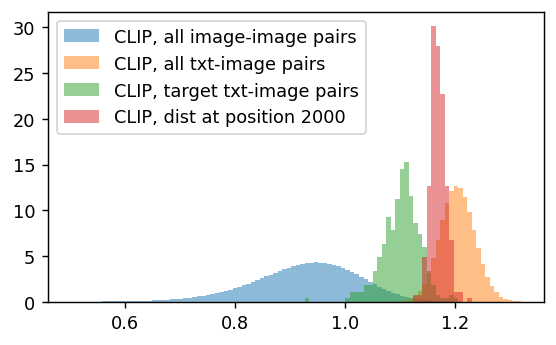

In [6]:
Clip_target_dists   = np.sqrt(((ClipQ_normed - ClipD_normed[targets]) ** 2).sum(axis=-1))
Clip_pair_dists     = np.sqrt(2 * (1 - ClipD_normed @ ClipD_normed.T) + 1e-4)
Clip_pair_txt_dists = np.sqrt(2 * (1 - ClipQ_normed @ ClipD_normed.T) + 1e-4)
Clip_2000_pos_dists = np.array([a[b] for a, b in zip(Clip_pair_txt_dists, np.argsort(Clip_pair_txt_dists)[:, 1999])])

Clip_pair_dists = Clip_pair_dists.reshape(-1)
Clip_pair_txt_dists = Clip_pair_txt_dists.reshape(-1)

Clip_pair_dists = Clip_pair_dists[Clip_pair_dists > 0.5]
print(f"{len(ClipD_normed) ** 2 - len(Clip_pair_dists)} (={100 * (1 - len(Clip_pair_dists) / len(ClipD_normed) ** 2):.1f}%) values out of graph range!")

plt.figure(figsize=(5,3), dpi=128)
plt.tight_layout()

_, bins, _ = plt.hist(Clip_pair_dists,     bins=100,  alpha=0.5, label="CLIP, all image-image pairs", density=True)
_, bins, _ = plt.hist(Clip_pair_txt_dists, bins=bins, alpha=0.5, label="CLIP, all txt-image pairs", density=True)
_, bins, _ = plt.hist(Clip_target_dists,   bins=bins, alpha=0.5, label="CLIP, target txt-image pairs", density=True)
_, bins, _ = plt.hist(Clip_2000_pos_dists, bins=bins, alpha=0.5, label="CLIP, dist at position 2000", density=True)
plt.legend(loc='upper left')
pass

145562 (=0.0%) values out of graph range!


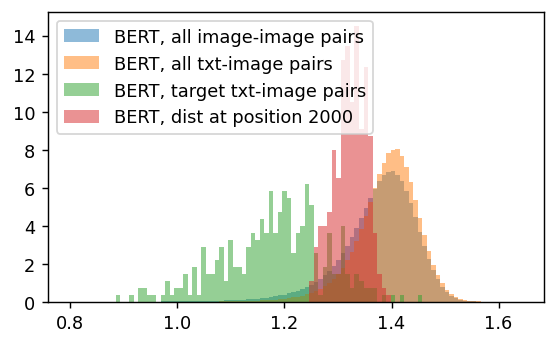

In [7]:
Bert_target_dists   = np.sqrt(((BertQ_normed - BertD_normed[targets]) ** 2).sum(axis=-1))
Bert_pair_dists     = np.sqrt(2 * (1 - BertD_normed @ BertD_normed.T) + 1e-4)
Bert_pair_txt_dists = np.sqrt(2 * (1 - BertQ_normed @ BertD_normed.T) + 1e-4)
Bert_2000_pos_dists = np.array([a[b] for a, b in zip(Bert_pair_txt_dists, np.argsort(Bert_pair_txt_dists)[:, 1999])])

Bert_pair_dists = Bert_pair_dists.reshape(-1)
Bert_pair_txt_dists = Bert_pair_txt_dists.reshape(-1)

Bert_pair_dists = Bert_pair_dists[Bert_pair_dists > 0.8]
print(f"{len(BertD_normed) ** 2 - len(Bert_pair_dists)} (={100 * (1 - len(Bert_pair_dists) / len(BertD_normed) ** 2):.1f}%) values out of graph range!")


plt.figure(figsize=(5,3), dpi=128)
plt.tight_layout()

_, bins, _ = plt.hist(Bert_pair_dists,     bins=100,  alpha=0.5, label="BERT, all image-image pairs", density=True)
_, bins, _ = plt.hist(Bert_pair_txt_dists, bins=bins, alpha=0.5, label="BERT, all txt-image pairs", density=True)
_, bins, _ = plt.hist(Bert_target_dists,   bins=bins, alpha=0.5, label="BERT, target txt-image pairs", density=True)
_, bins, _ = plt.hist(Bert_2000_pos_dists, bins=bins, alpha=0.5, label="BERT, dist at position 2000", density=True)
plt.legend(loc='upper left')
pass